# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense,GRU, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

# Explore Data

In [2]:
data_dir = '../input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv'
data = pd.read_csv(data_dir,parse_dates=True,index_col='date')

In [3]:
data.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
data.tail()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762
2016-12-31,15.052632,87.000000,7.325000,1016.100000
2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [6]:
data.shape

(1462, 4)

# Data Analysis

In [7]:
data.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


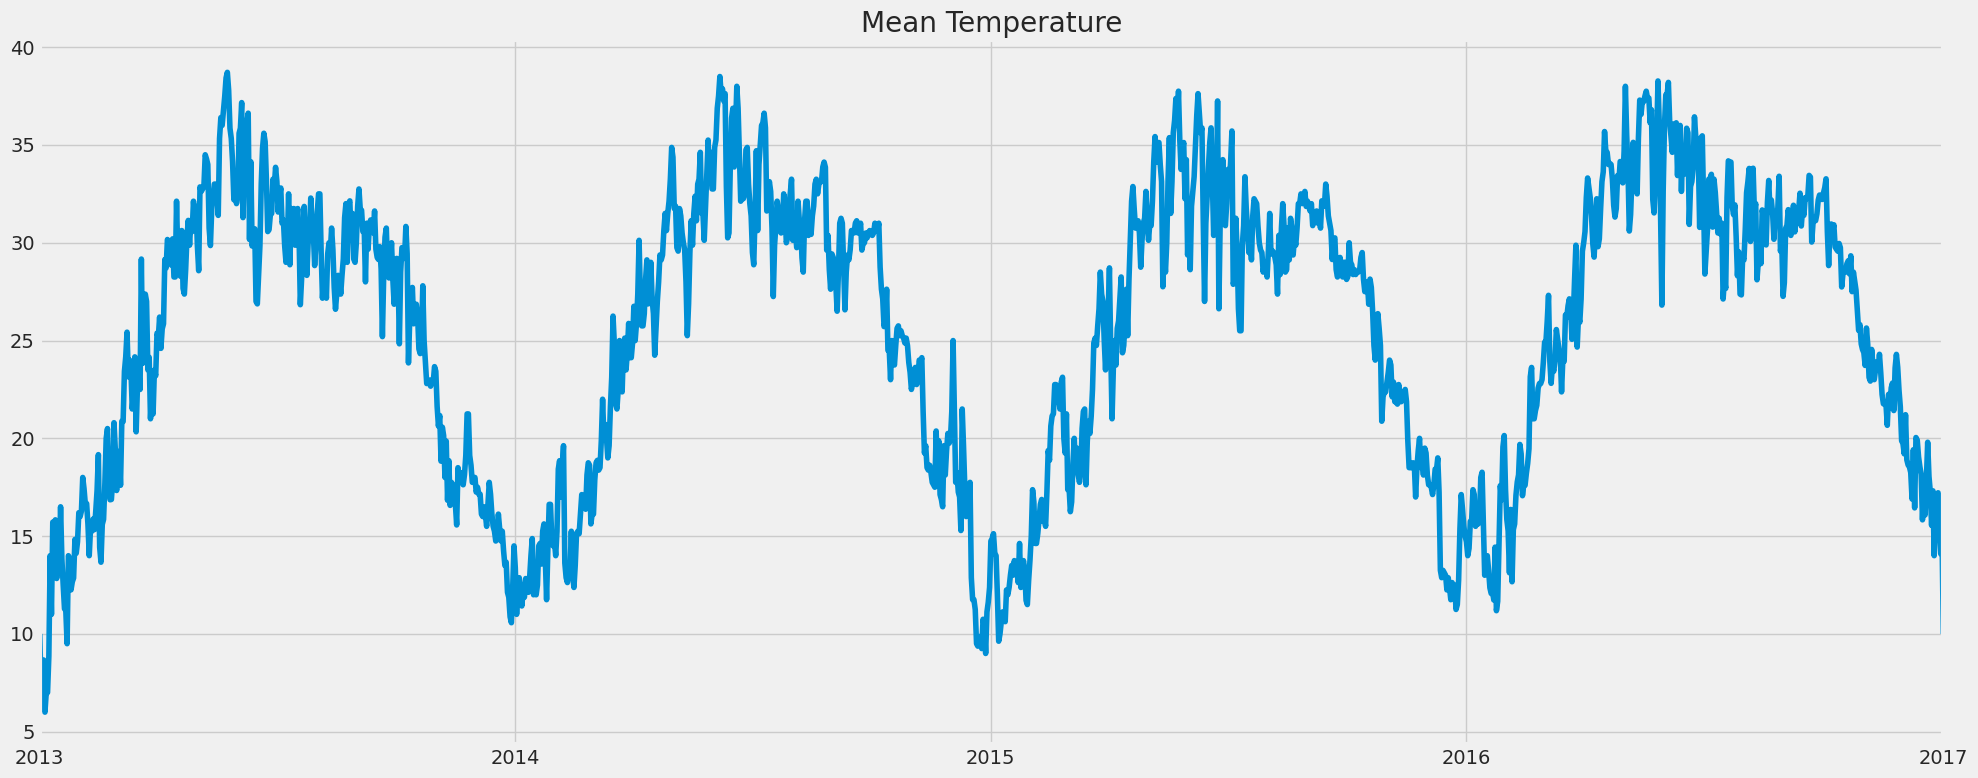

In [8]:
plt.figure(figsize=(20, 8))
data['meantemp'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Mean Temperature")
plt.tight_layout()
plt.show()

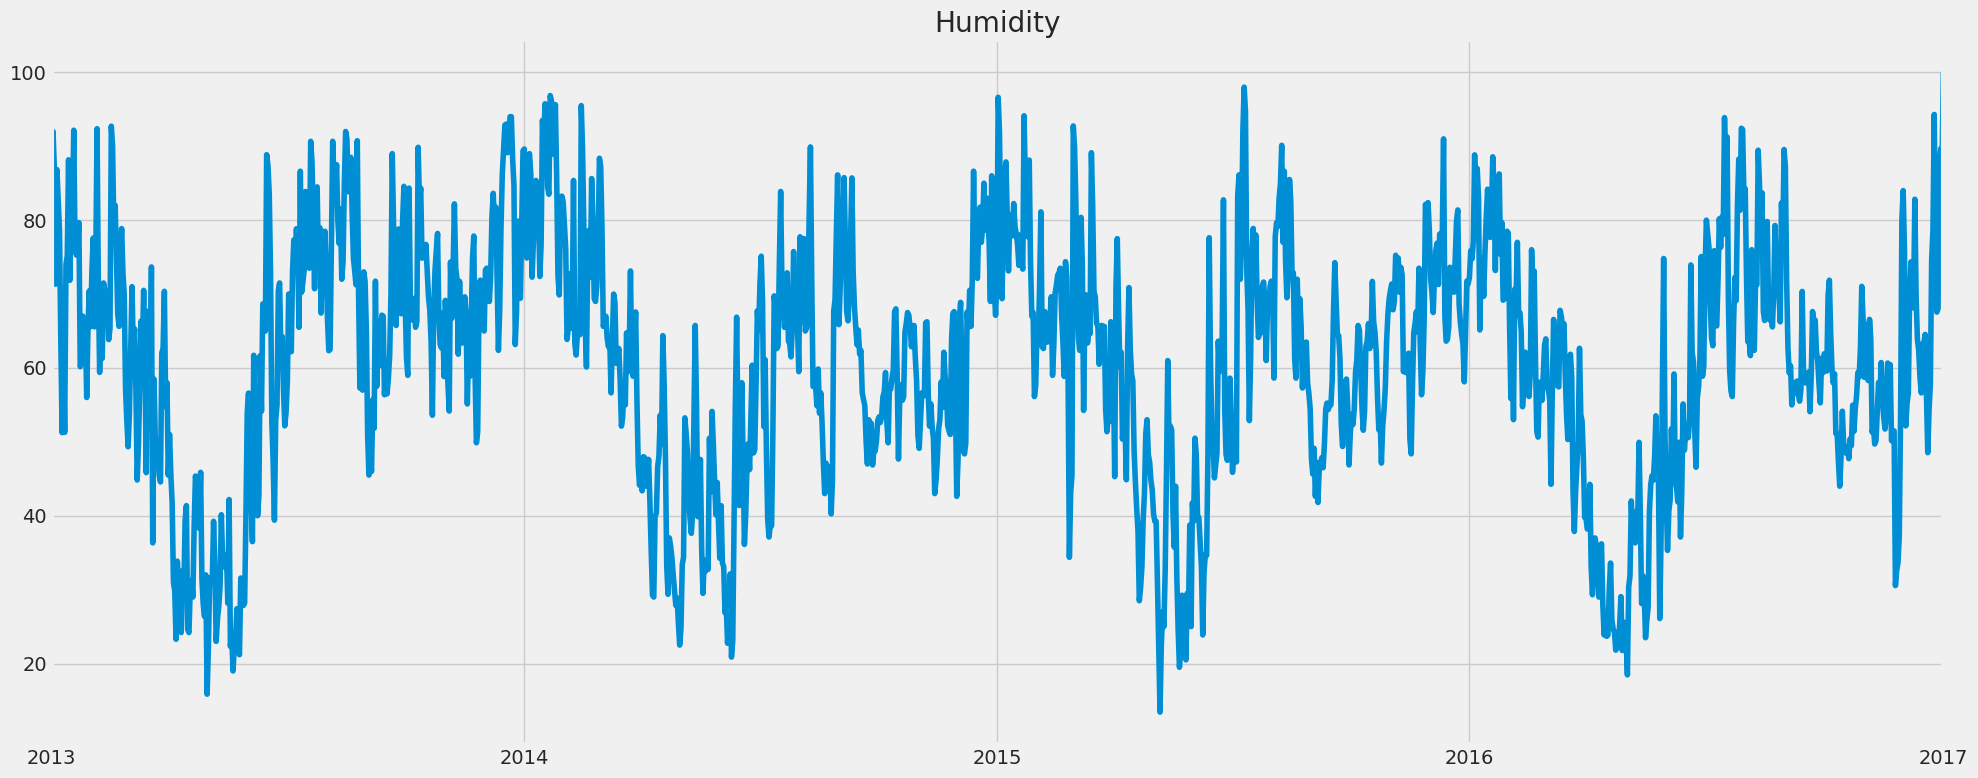

In [9]:
plt.figure(figsize=(20, 8))
data['humidity'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Humidity")
plt.tight_layout()
plt.show()

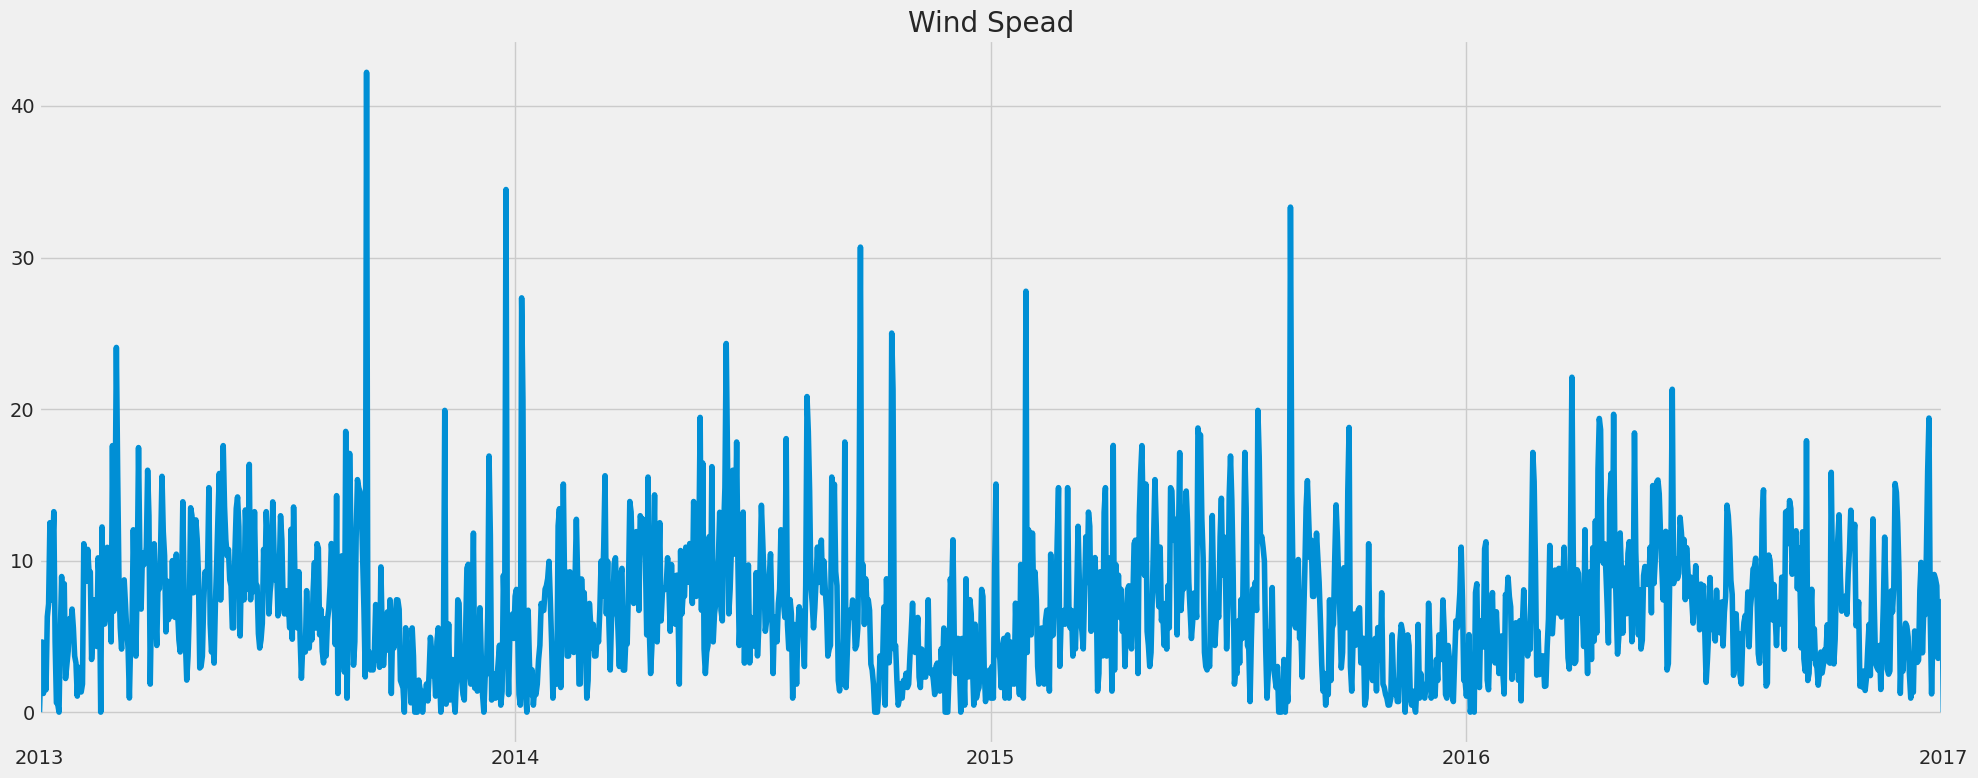

In [10]:
plt.figure(figsize=(20, 8))
data['wind_speed'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Wind Spead")
plt.tight_layout()
plt.show()

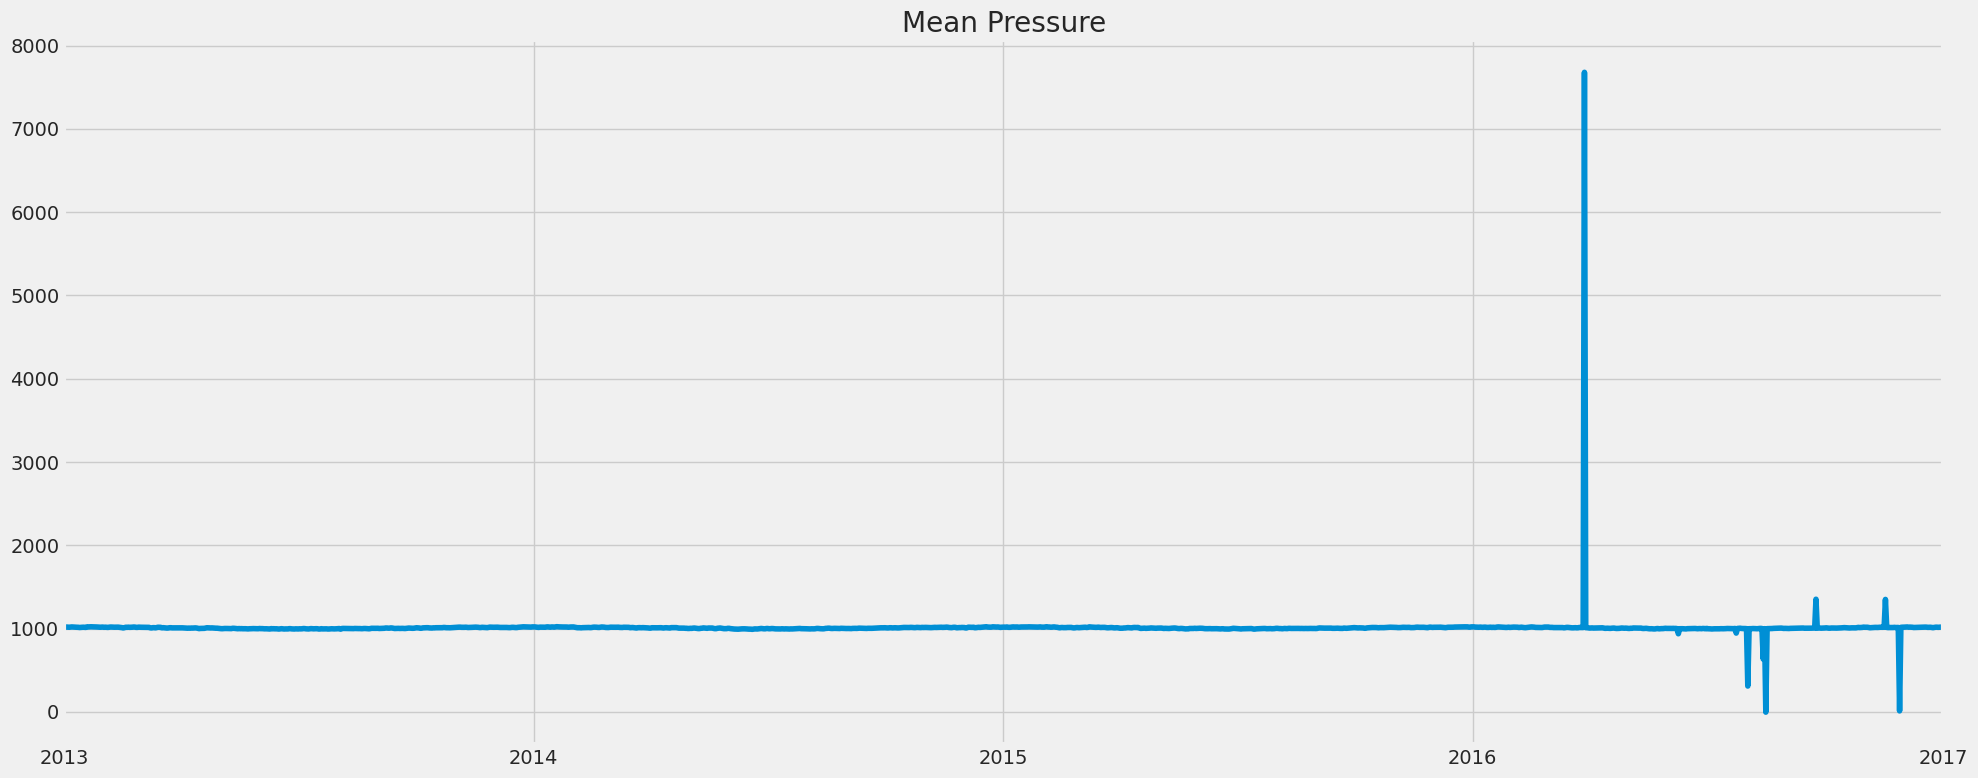

In [11]:
plt.figure(figsize=(20, 8))
data['meanpressure'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Mean Pressure")
plt.tight_layout()
plt.show()

In [ ]:
# ----- RESAMPLING: Resample Data to Monthly Frequency -----
# Resample the data by month and calculate the mean for each month
data_monthly = data.resample('M').mean()  # Resample by month and calculate mean
plt.figure(figsize=(20, 8))
data_monthly['meantemp'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Monthly Mean Temperature")
plt.tight_layout()
plt.show()

In [ ]:
# ----- ROLLING STATISTICS: Calculate 7-day Rolling Mean and Rolling Std -----
# Calculate the rolling mean (7 days) and rolling standard deviation (7 days)
data['rolling_mean'] = data['meantemp'].rolling(window=7).mean()
data['rolling_std'] = data['meantemp'].rolling(window=7).std()

plt.figure(figsize=(20, 8))
plt.plot(data['meantemp'], label='Original Data')
plt.plot(data['rolling_mean'], label='7-Day Rolling Mean', color='red')
plt.plot(data['rolling_std'], label='7-Day Rolling Std', color='green')
plt.title('7-Day Rolling Mean and Standard Deviation')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ----- LAGGING: Create Lag Features (Lag 1, Lag 2) -----
# Create lag features (Lag 1: previous day, Lag 2: two days ago)
data['lag_1'] = data['meantemp'].shift(1)  # Lag by 1 day
data['lag_2'] = data['meantemp'].shift(2)  # Lag by 2 days

# Visualize lagged values along with the original data
plt.figure(figsize=(20, 8))
plt.plot(data['meantemp'], label='Original Data')
plt.plot(data['lag_1'], label='Lag 1', color='orange')
plt.plot(data['lag_2'], label='Lag 2', color='purple')
plt.title('Lagged Values (Lag 1 and Lag 2)')
plt.legend()
plt.tight_layout()
plt.show()

# Data Preprocessing

### Choosing Prediction Column

In [12]:
num_col= 1
df=data['meantemp']
df=pd.DataFrame(df)
dataset=df.values

dataset.shape

(1462, 1)

### Split Data

In [13]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 1169 Test Size : 293


In [14]:
train_data = dataset[0:train_size, :]
train_data.shape

(1169, 1)

### Creat Train Set

In [15]:
x_train = []
y_train = []
time_steps = 60
num_col= 1

for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, :num_col])
    y_train.append(train_data[i, :num_col])

In [16]:
len(x_train)

1109

In [17]:
len(y_train)

1109

In [18]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [19]:
x_train.shape

(1109, 60, 1)

In [20]:
x_train.shape , y_train.shape

((1109, 60, 1), (1109, 1))

# LSTM Model

### Model Structure

In [21]:
model_LSTM = Sequential([
    LSTM(64, return_sequences= True, input_shape= (x_train.shape[1],x_train.shape[2])),
    GRU(64, return_sequences= True),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(num_col)
])

model_LSTM.compile(optimizer= 'adam', loss= 'mse')

In [22]:
model_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 60, 64)         │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,505 (302.75 KB)

 Trainable params: 77,505 (302.75 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [23]:
history = model_LSTM.fit(x_train, y_train, epochs= 100, batch_size= 32)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 416.7426
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 57.9778
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 30.9355
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 4.3120
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 4.0974
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 3.7824
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 3.8260
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 3.4652
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 3.3755
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 3.1471
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 3.0895
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 3.0516
Epoch 13/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 3.0328
Epoch 14/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 3.4155
Epoch 15/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step 

### Model Evaluation

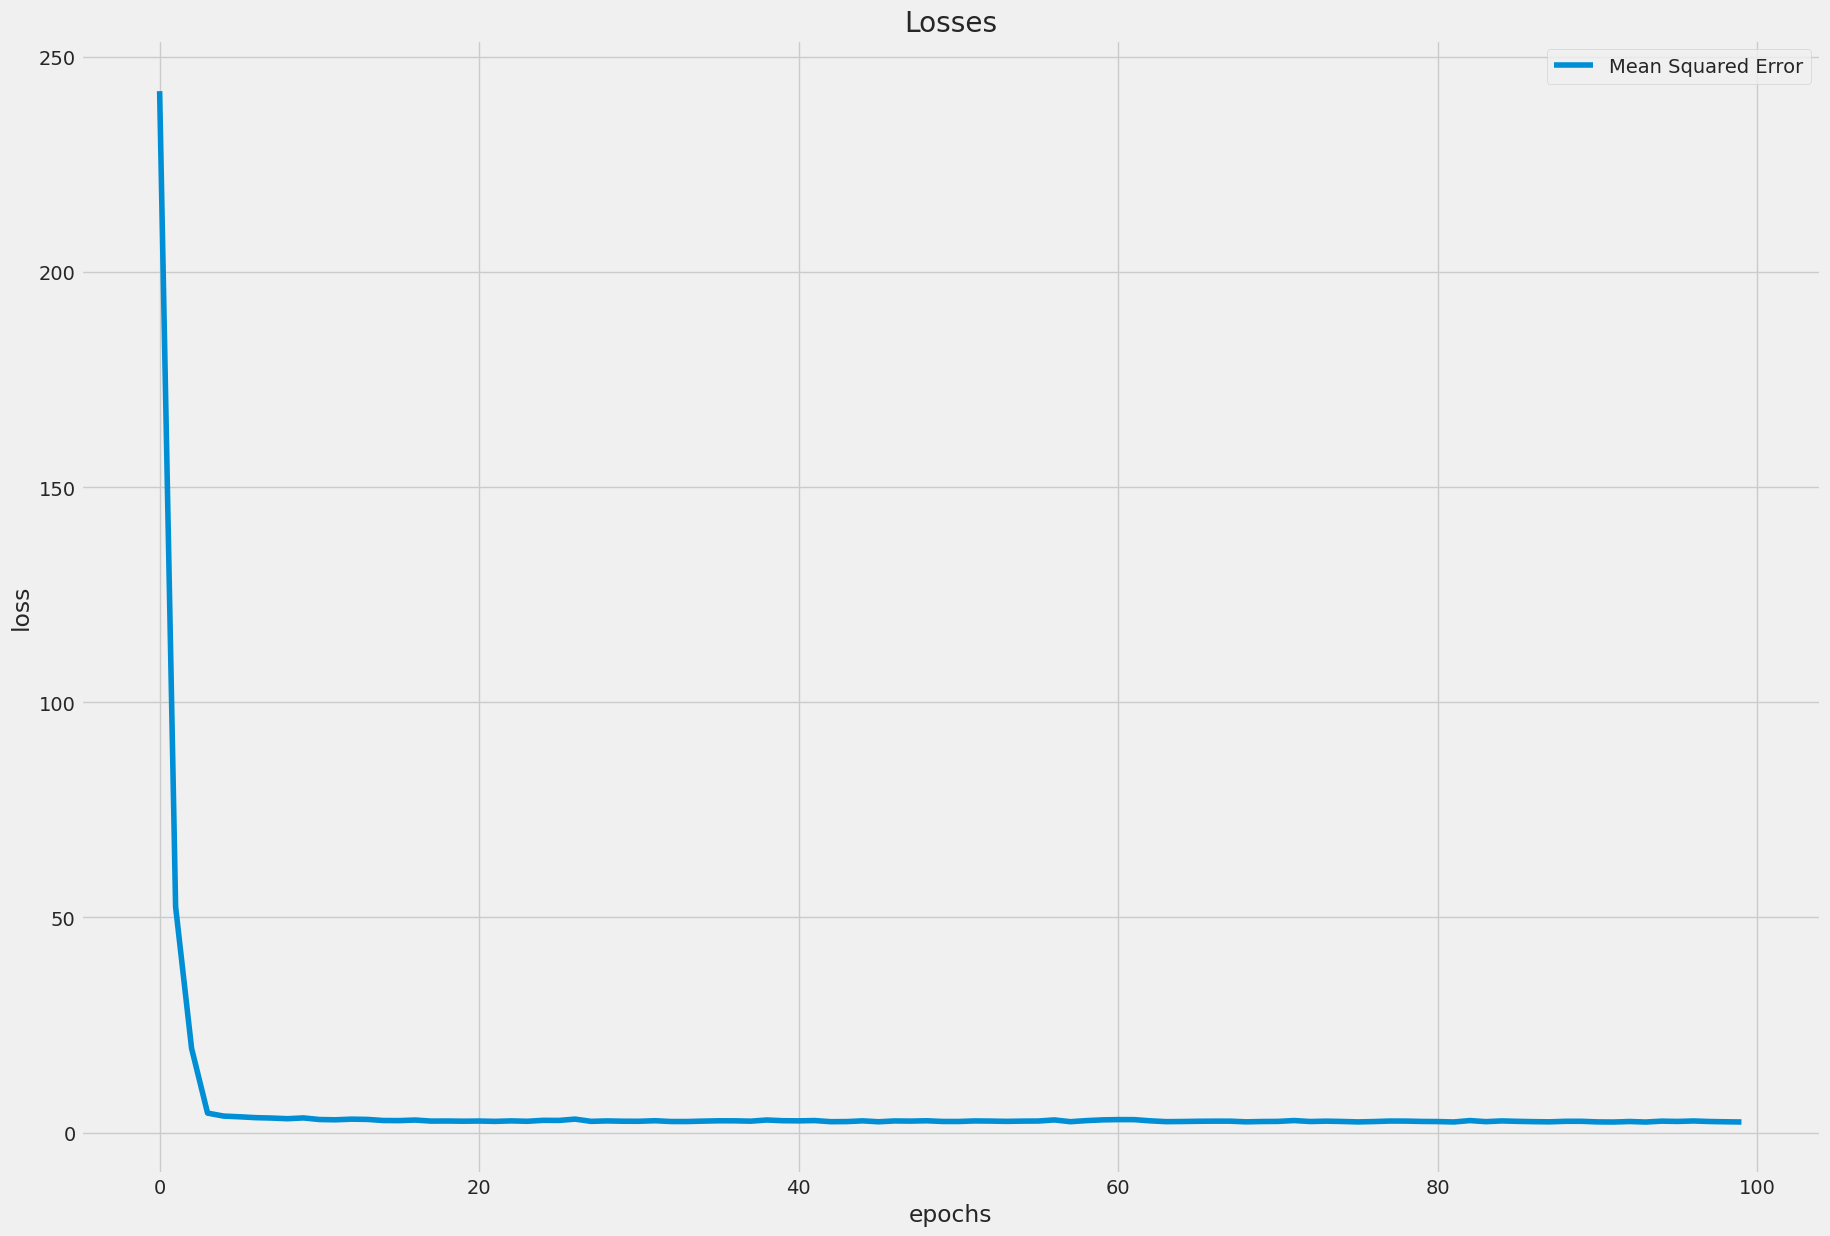

In [24]:
plt.figure(figsize=(20, 14))
plt.plot(history.history["loss"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Predection

### Creat test set

In [25]:
time_steps = 60
test_data = dataset[train_size - time_steps:, :]

x_test = []
y_test = []
num_col = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:num_col])
    y_test.append(test_data[i, 0:num_col])
x_test, y_test = np.array(x_test), np.array(y_test)

In [26]:
x_test.shape

(293, 60, 1)

In [27]:
predictions = model_LSTM.predict(x_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


In [28]:
predictions.shape

(293, 1)

In [29]:
y_test.shape

(293, 1)

In [30]:
predictions

array([[22.452654],
       [23.944935],
       [23.455822],
       [25.26779 ],
       [25.076357],
       [25.663876],
       [25.968985],
       [25.663752],
       [24.730232],
       [25.6831  ],
       [26.749203],
       [27.773241],
       [24.34495 ],
       [26.151937],
       [25.503721],
       [26.337975],
       [27.862173],
       [28.14599 ],
       [28.824818],
       [30.470068],
       [31.430368],
       [31.442   ],
       [31.116175],
       [30.525578],
       [29.449587],
       [28.994204],
       [30.121511],
       [31.243301],
       [29.313257],
       [29.606125],
       [30.945002],
       [31.881258],
       [32.351536],
       [33.840008],
       [33.581764],
       [33.27768 ],
       [32.97264 ],
       [32.96665 ],
       [33.000183],
       [32.424496],
       [31.31458 ],
       [30.81405 ],
       [31.177427],
       [32.442596],
       [32.291286],
       [32.86037 ],
       [33.03582 ],
       [32.156868],
       [33.243435],
       [35.339092],


### Root mean square error

In [31]:
RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

0.86

In [32]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,22.452654,24.066667
1,23.944935,23.937500
2,23.455822,26.312500
3,25.267790,26.187500
4,25.076357,26.785714
...,...,...
288,16.188116,17.217391
289,16.235565,15.238095
290,14.941737,14.095238
291,13.830306,15.052632


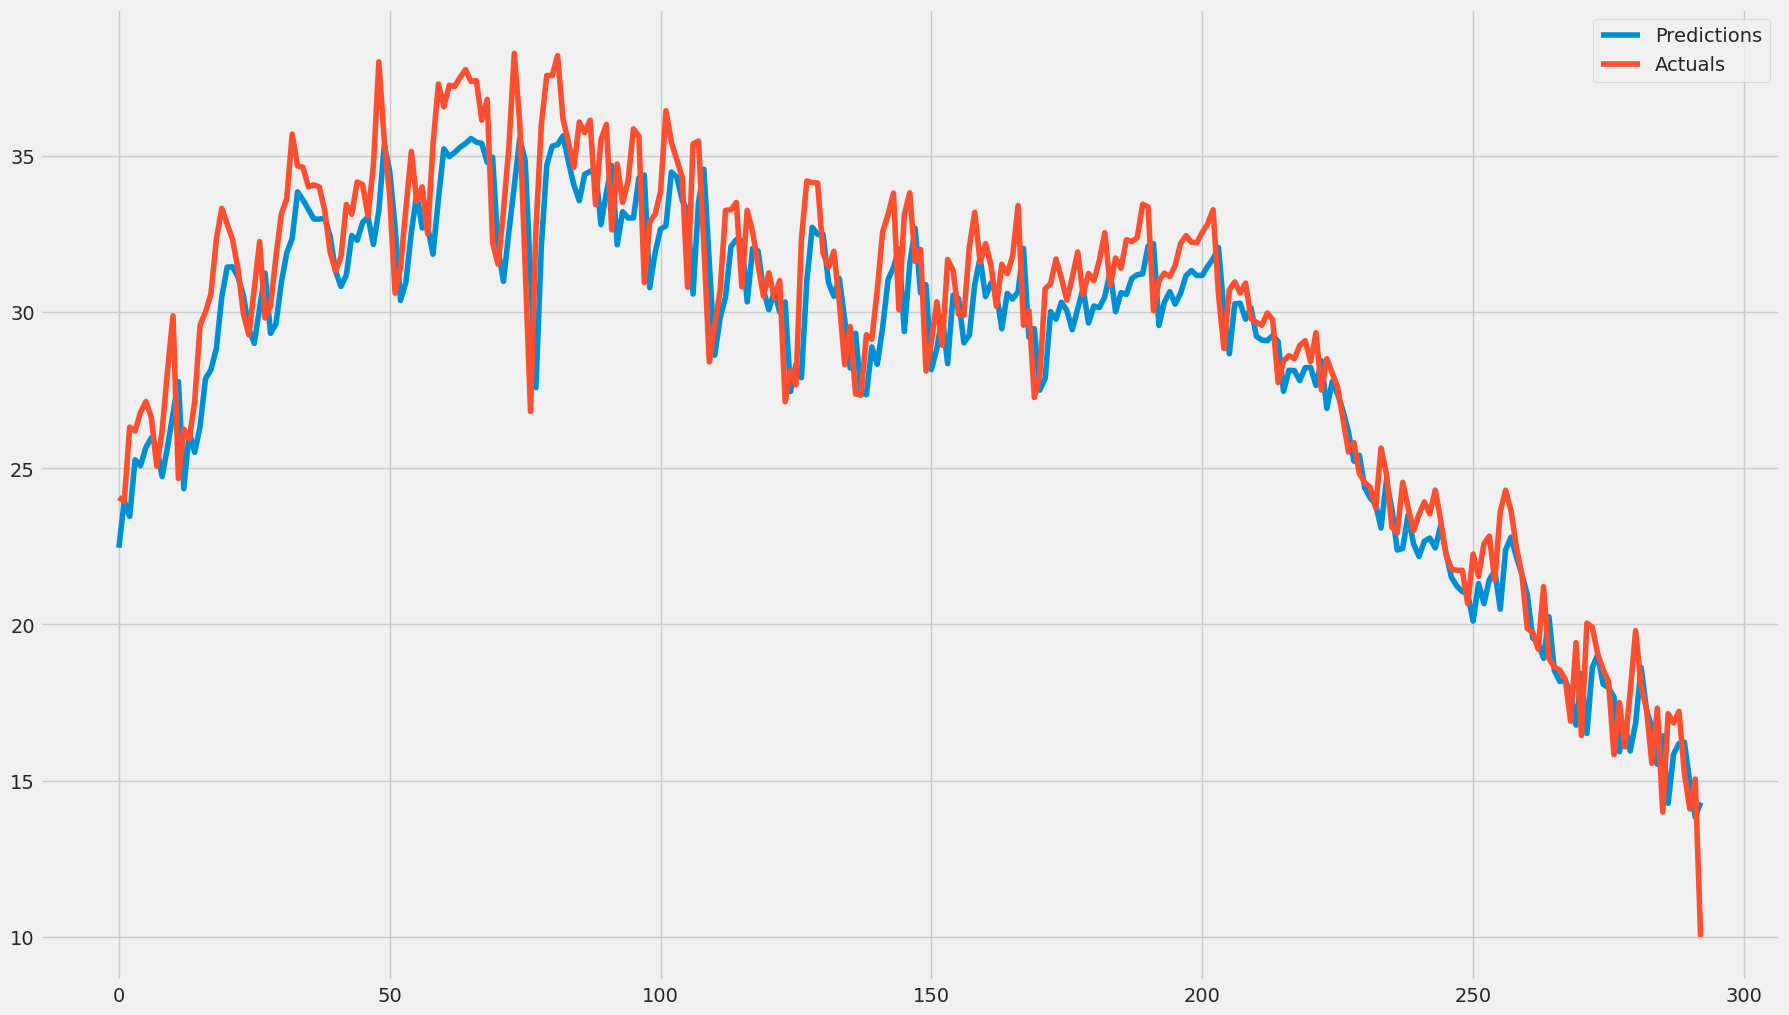

In [33]:
plt.figure(figsize = (20, 12))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

### Visualize Predictions with The Data

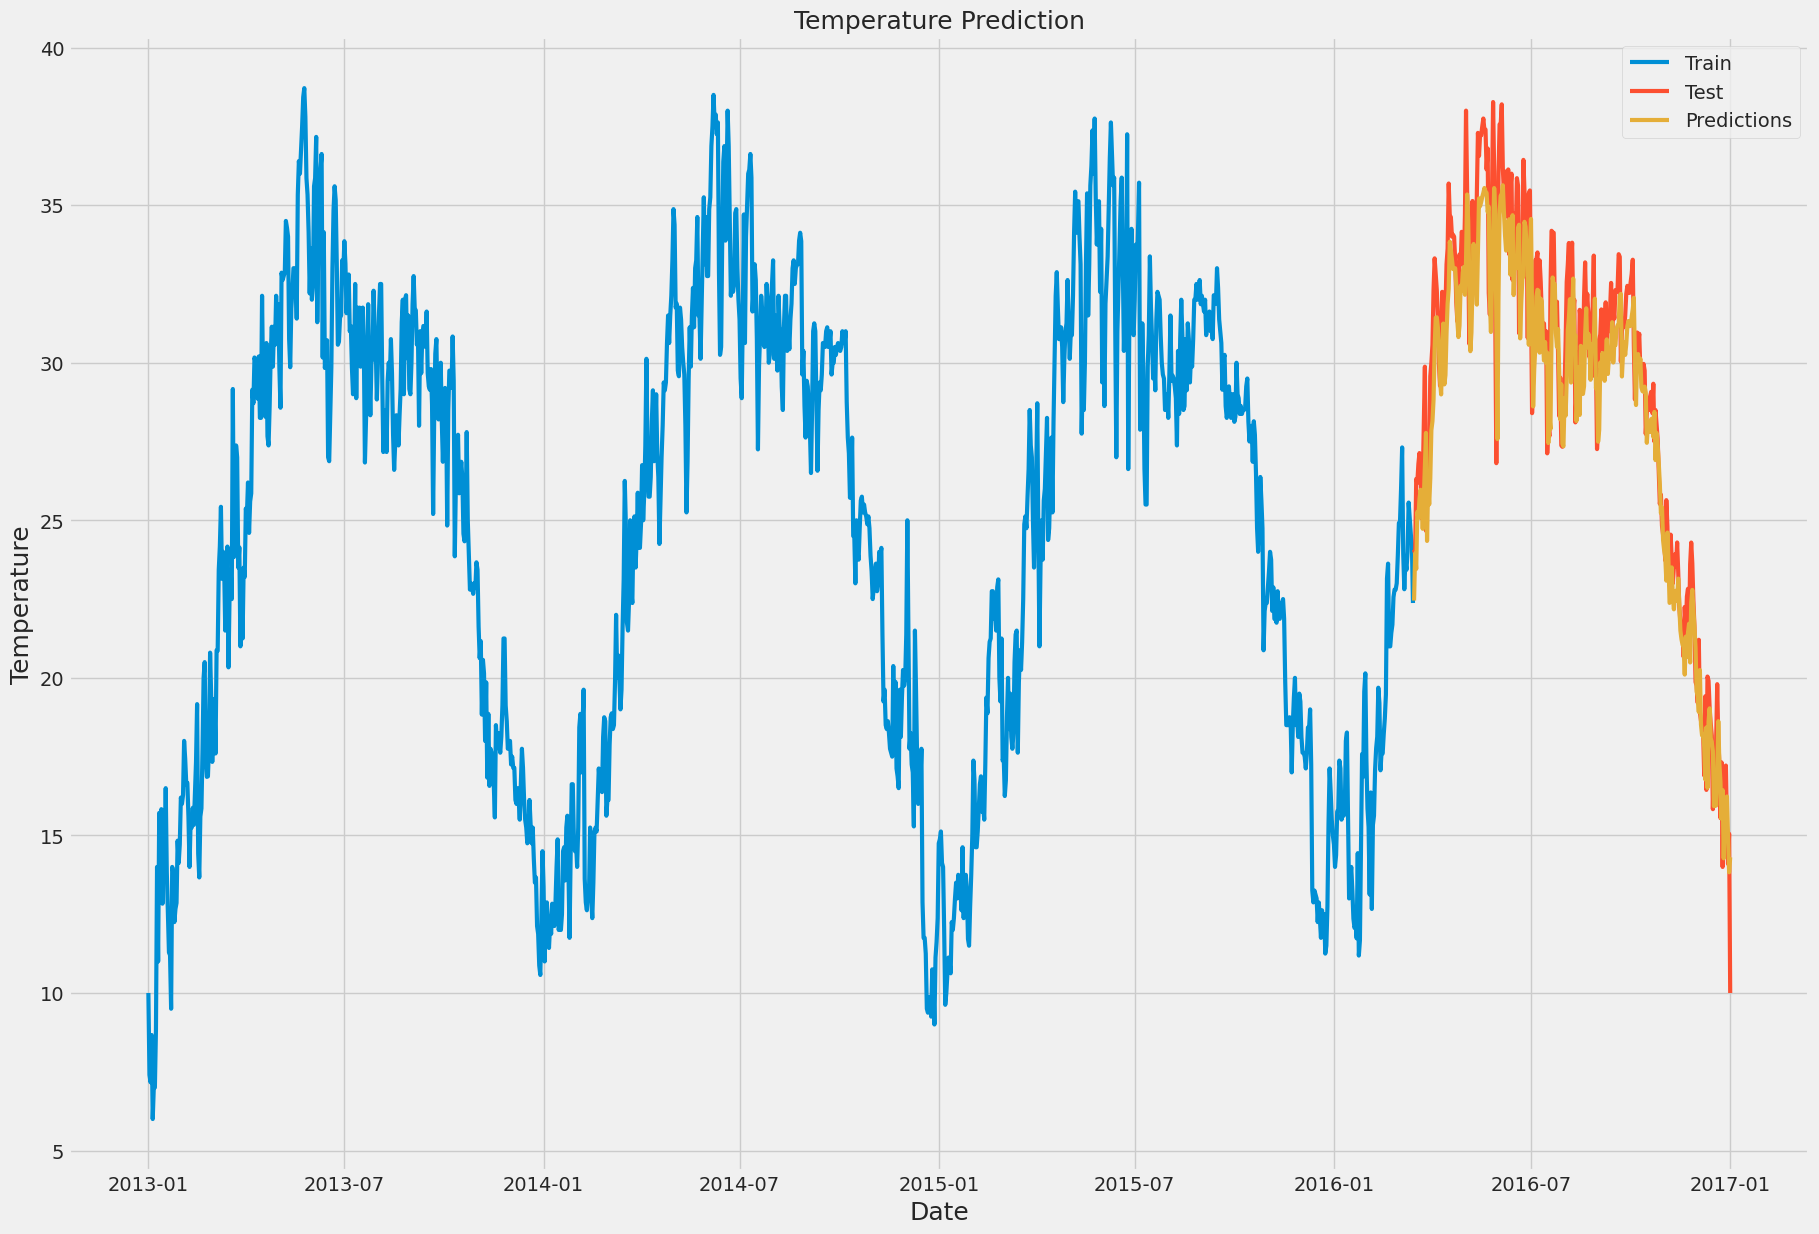

In [34]:
train = df.iloc[:train_size , 0:1]
test = df.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (20, 14))
plt.title('Temperature Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Temperature', fontsize= 18)
plt.plot(train['meantemp'], linewidth= 3)
plt.plot(test['meantemp'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

# Multivariate Predection

In [35]:
data.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


### Choose Columns

In [36]:
num_col = 4
df = data[['meantemp', 'humidity', 'wind_speed','meanpressure']]
df = pd.DataFrame(df)
dataset = df.values

dataset.shape

(1462, 4)

# Data Preprocessing

### Data Splitting

In [37]:
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 1096 Test Size : 366


In [38]:
train_data = dataset[0:train_size, :]
train_data.shape

(1096, 4)

In [39]:
train_data

array([[  10.        ,   84.5       ,    0.        , 1015.66666667],
       [   7.4       ,   92.        ,    2.98      , 1017.8       ],
       [   7.16666667,   87.        ,    4.63333333, 1018.66666667],
       ...,
       [  15.5       ,   71.75      ,    2.1       , 1017.5       ],
       [  15.        ,   71.375     ,    2.0875    , 1020.5       ],
       [  14.71428571,   72.28571429,    1.05714286, 1021.14285714]])

### Creat Train Data

In [40]:
x_train = []
y_train = []
time_steps = 60
num_col = 4

for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, :num_col])
    y_train.append(train_data[i, :num_col])

In [41]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [42]:
x_train.shape

(1036, 60, 4)

### Model Structure

In [43]:
model2 = Sequential([
    LSTM(64, return_sequences= True, input_shape= (x_train.shape[1], x_train.shape[2])),
    LSTM(64, return_sequences= True),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(num_col)
])

model2.compile(optimizer= 'adam', loss= 'mse' )

In [44]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,388 (337.45 KB)

 Trainable params: 86,388 (337.45 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
history2 = model2.fit(x_train, y_train, epochs= 100, batch_size= 32)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 252782.3750
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 231025.7969
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 181795.8594
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 104522.4766
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 31125.5410
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 2157.1763
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 106.4146
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 104.2697
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 105.0167
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 100.8572
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 103.8980
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 102.9734
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 108.7500
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 107.9365
Epoch 15/100
3

### Model Evaluation

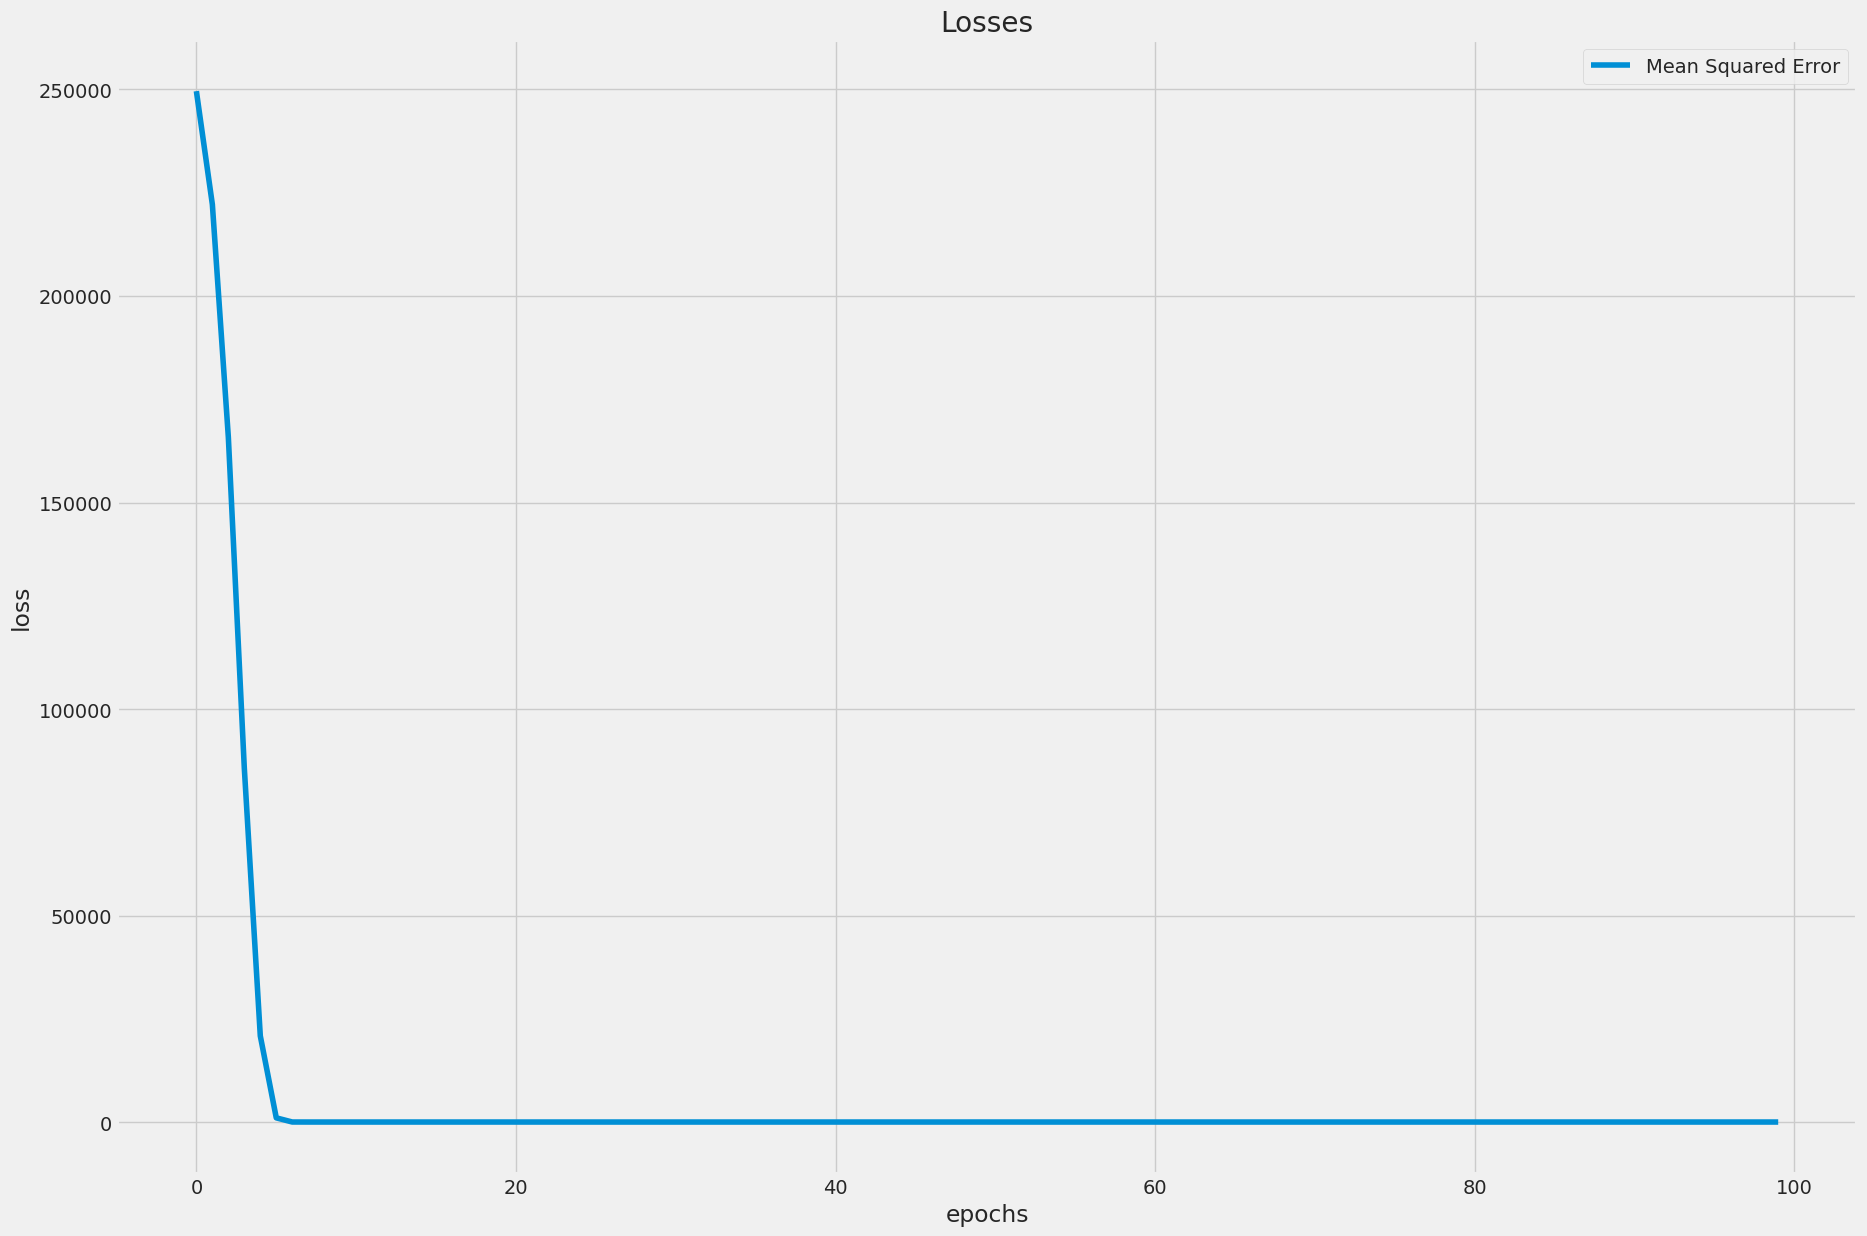

In [46]:
plt.figure(figsize=(20, 14))
plt.plot(history2.history["loss"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Prediction

### Creat Test Data

In [47]:
time_steps = 60
test_data = dataset[train_size - time_steps:, :]

x_test = []
y_test = []
num_col = 4

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:num_col])
    y_test.append(test_data[i, 0:num_col])
x_test, y_test = np.array(x_test), np.array(y_test)

In [48]:
x_test.shape , y_test.shape

((366, 60, 4), (366, 4))

In [49]:
predictions = model2.predict(x_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


In [50]:
predictions[0:10]

array([[  25.352451,   61.813038,    7.173914, 1007.32404 ],
       [  25.352451,   61.813038,    7.173914, 1007.32404 ],
       [  25.352451,   61.813038,    7.173914, 1007.32404 ],
       [  25.352451,   61.813038,    7.173914, 1007.32404 ],
       [  25.352451,   61.813038,    7.173914, 1007.32404 ],
       [  25.352451,   61.813038,    7.173914, 1007.32404 ],
       [  25.352451,   61.813038,    7.173914, 1007.32404 ],
       [  25.352451,   61.813038,    7.173914, 1007.32404 ],
       [  25.352451,   61.813038,    7.173914, 1007.32404 ],
       [  25.352451,   61.813038,    7.173914, 1007.32404 ]],
      dtype=float32)

In [51]:
RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

2.74

# Forcasting

In [52]:
from datetime import timedelta

In [53]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [54]:
future = 30
forcast = []
time = []
Xin = x_test[-1:, :, :]
for i in range(future):
    out = model2.predict(Xin)
    forcast.append(out[0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[array([  25.352413 ,   61.813038 ,    7.1739197, 1007.32385  ],
      dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[array([  25.352413 ,   61.813038 ,    7.1739197, 1007.32385  ],
      dtype=float32), array([  25.35225 ,   61.812572,    7.173853, 1007.3166  ], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[array([  25.352413 ,   61.813038 ,    7.1739197, 1007.32385  ],
      dtype=float32), array([  25.35225 ,   61.812572,    7.173853, 1007.3166  ], dtype=float32), array([  25.352219 ,   61.812504 ,    7.1738663, 1007.31525  ],
      dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[array([  25.352413 ,   61.813038 ,    7.1739197, 1007.32385  ],
      dtype=float32), array([  25.35225 ,   61.812572,    7.173853, 1007.3166  ], dtype=float32), array([  25.352219 ,   61.812504 ,    7.1738663, 1007.31525  ],
      dtype=float32), array([  25.352226 ,   61.812504 ,    7.1738243, 1007.3148   ],
      dtype=float32)]
1/1 ━━━━━━━━━━

In [55]:
forcasted_output = np.asanyarray(forcast)   

In [56]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", 'meantemp', 'humidity', 'wind_speed', 'meanpressure'
df_result.head()

,Date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,25.352413,61.813038,7.173920,1007.323853
1,2017-01-02,25.352249,61.812572,7.173853,1007.316589
2,2017-01-03,25.352219,61.812504,7.173866,1007.315247
3,2017-01-04,25.352226,61.812504,7.173824,1007.314819
4,2017-01-05,25.352211,61.812504,7.173847,1007.314697


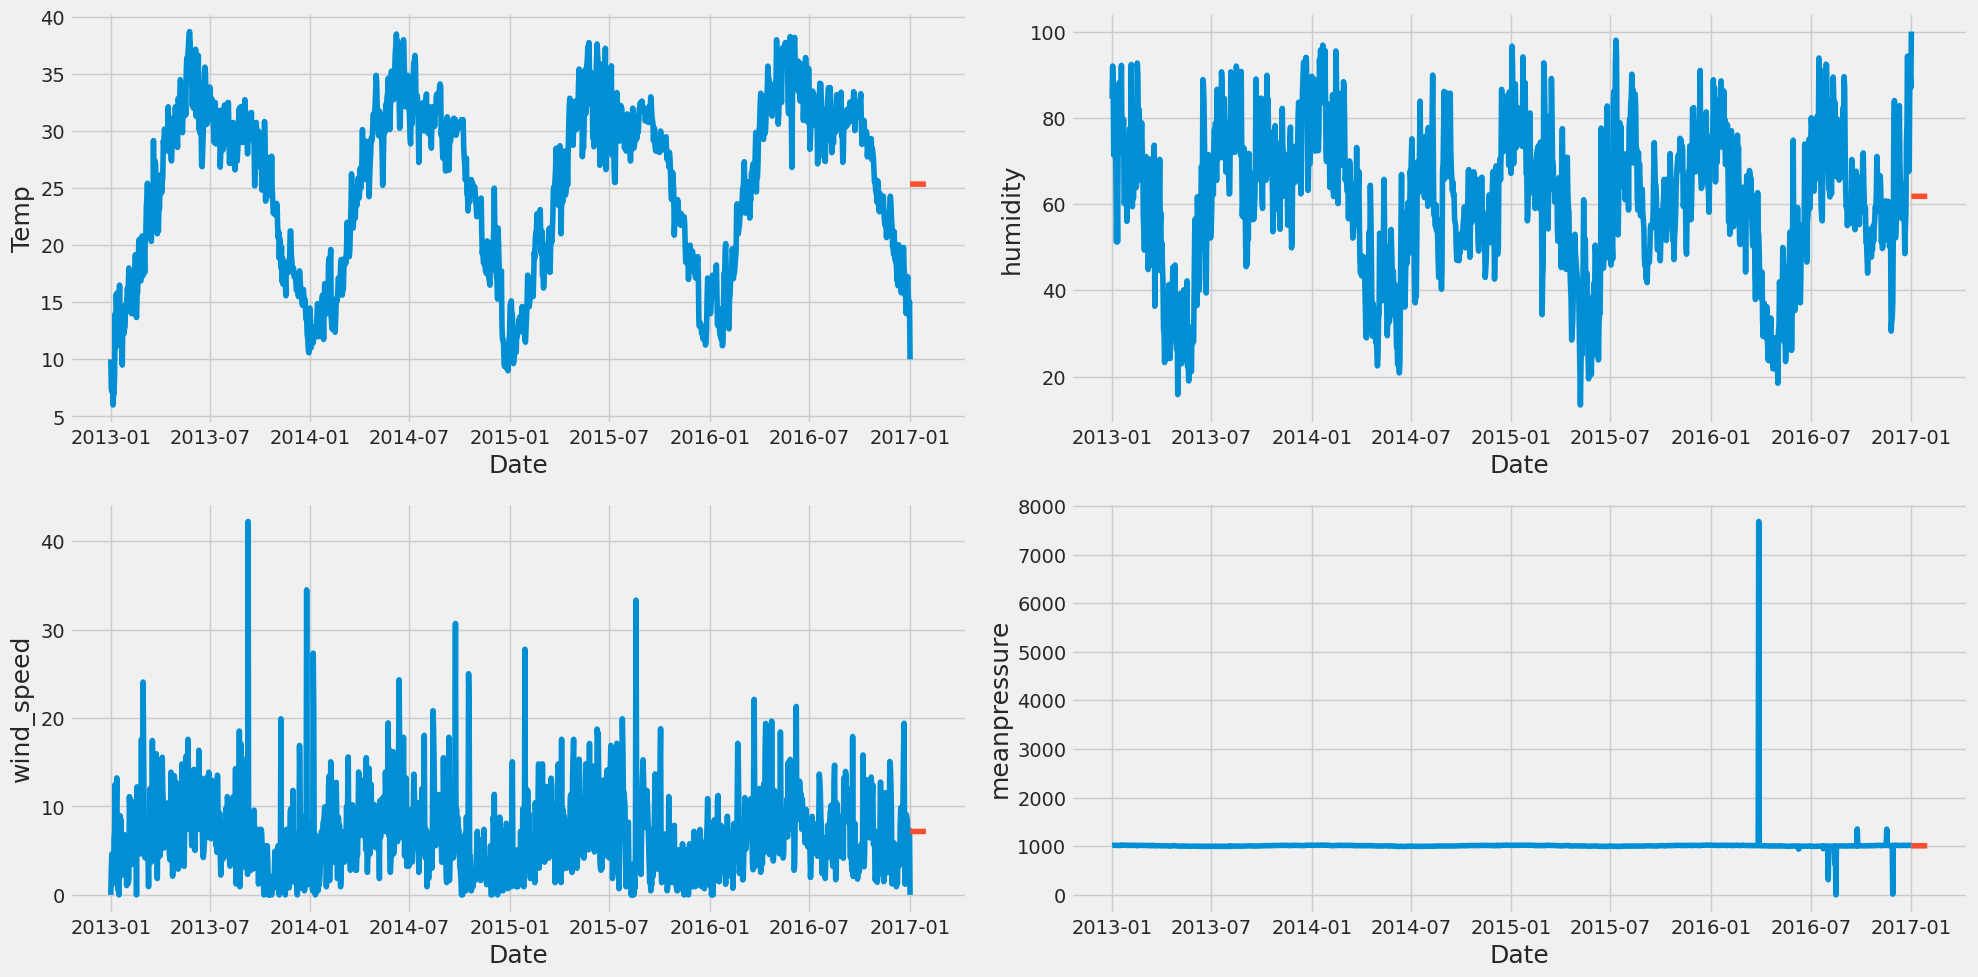

In [57]:
plt.figure(figsize=(20, 10))
plt.title('Next 30 Days')

plt.subplot(2, 2, 1)
plt.plot(data['meantemp'])
plt.plot(df_result.set_index('Date')[['meantemp']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Temp' ,fontsize=18)

plt.subplot(2, 2, 2)
plt.plot(data['humidity'])
plt.plot(df_result.set_index('Date')[['humidity']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('humidity' ,fontsize=18)

plt.subplot(2, 2, 3)
plt.plot(data['wind_speed'])
plt.plot(df_result.set_index('Date')[['wind_speed']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('wind_speed' ,fontsize=18)

plt.subplot(2, 2, 4)
plt.plot(data['meanpressure'])
plt.plot(df_result.set_index('Date')[['meanpressure']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('meanpressure' ,fontsize=18)

plt.tight_layout()
plt.show()